In [1]:
from options.train_options import TrainOptions
from options.test_options import TestOptions
from data import CustomDatasetDataLoader
from models import create_model
import sys
import os
from PIL import Image

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import util.util as util
import matplotlib.pyplot as plt
#import cv2
import time

In [2]:
def progressbar(it, info_dict, size=60, out=sys.stdout): # Python3.3+
    count = len(it)
    def show(j, batch_size):
        n = batch_size*j
        x = int(size*n/count)
        
        taken_time = time.time() - info_dict["start time"]
        print("{} [{}{}] {}/{} | {:.3f} secs".format(info_dict["epoch"], "#"*x, "."*(size-x), n, count, taken_time), 
                end='\r', file=out, flush=True)
    show(0, 1)
    for i, item in enumerate(it):
        yield i, item
        batch_size = len(list(item.values())[0])
        show(i+1, batch_size)
    print("", flush=True, file=out) #Do thing after ending iteration
    
def print_current_losses(log_dir, epoch, lr, iters, losses, t_comp, t_data):
    """print current losses on console; also save the losses to the disk

    Parameters:
        epoch (int) -- current epoch
        iters (int) -- current training iteration during this epoch (reset to 0 at the end of every epoch)
        losses (OrderedDict) -- training losses stored in the format of (name, float) pairs
        t_comp (float) -- computational time per data point (normalized by batch_size)
        t_data (float) -- data loading time per data point (normalized by batch_size)
    """
    message = '{\"epoch\": %d, \"iters\": %d, \"lr\": %.6f, \"computing time\": %.3f, \"data_load_time\": %.3f ' % (epoch, iters, lr, t_comp, t_data)
    for k, v in losses.items():
        message += ', \"%s\": %.3f ' % (k, v)
    message += '}'

    print(" - " + log_dir[-9:] + " : " + message)  # print the message
    with open(log_dir, "a+") as log_file:
        log_file.write('%s\n' % message)  # save the message

In [3]:
opt = TrainOptions()

----------------- Options ---------------
               batch_size: 2                             
                    beta1: 0.5                           
          checkpoints_dir: C:/Users/m1101/Downloads/Shadow_Removal/SID/_Git_SID/checkpoints_PAMI/
                 dataroot: C:/Users/m1101/Downloads/Shadow_Removal/SID/_Git_SID/data_processing/dataset/NTUST_TU/train/
             dataset_mode: shadowparam                   
                    epoch: latest                        
              epoch_count: 1                             
                 fineSize: 256                           
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: xavier                        
                 input_nc: 3                             
                  isTrain: True                          	[default: None]
                lambda_L1: 100                           
                 loadSize: 2

In [4]:
train_options.dataset_mode = "shadowparam"
train_options.data_root = "C:/Users/m1101/Downloads/Shadow_Removal/SID/_Git_SID/data_processing/dataset/NTUST_TU/train/"
opt = train_options.parse()
data_loader = CustomDatasetDataLoader(opt) #createDataLoader(opt)
dataset = data_loader.load_data()
dataset_size = len(data_loader)

dataset [ShadowParamDataset] was created


In [5]:
train_options.model_name = "SID"
opt = train_options.parse()
model = create_model(opt)
model.setup(opt)

initialize network with xavier
model [Shadow Image Decomposition model ICCV19] was created
<bound method SIDModel.name of <models.model_SID.SIDModel object at 0x0000025E69365A30>>
---------- Networks initialized -------------
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [6]:
cuda_tensor = torch.cuda.FloatTensor if len(opt.gpu_ids) > 0 else torch.FloatTensor

for epoch in range(opt.epoch_count, opt.niter + opt.niter_decay + 1):
    epoch_start_time = time.time()
    #model.epoch = epoch
    epoch_iter = 0
    t_comp, t_data = 0, 0
    train_losses = dict()
    
    dataset.working_subset = "train"
    progressbar_info = {"epoch": "epoch {}/{} ".format(epoch, opt.niter + opt.niter_decay), 
                        "start time": epoch_start_time}
    for i, data in progressbar(dataset, progressbar_info):
        iter_start_time = time.time() #the time after loading data
        epoch_iter += opt.batch_size
        model.set_input(data)
        model.optimize_parameters()
        #model.cepoch=epoch
        t_comp += time.time() - iter_start_time #computing time after loading data
        
        current_losses = model.get_current_losses()
        train_losses = {key: train_losses.get(key,0) + current_losses[key] for key in set(train_losses).union(current_losses)}
    
    n_train_losses = epoch_iter/opt.batch_size
    train_losses = {key: train_losses[key]/n_train_losses for key in train_losses.keys()}
    current_lr = model.update_learning_rate()
    t_data = time.time() - epoch_start_time - t_comp
    print_current_losses(os.path.join(opt.checkpoints_dir, opt.name, 'train.log'), epoch, current_lr, \
                             epoch_iter, train_losses, t_comp, t_data)
    
    valid_losses, n_valid_loss = 0, 0
    with torch.no_grad():
        dataset.working_subset = "valid"
        for _, data in enumerate(dataset, 0):
            full_shadow_img = Variable(data['A'].type(cuda_tensor))
            shadow_mask = Variable(data['B'].type(cuda_tensor))
            shadowfree_img = Variable(data['C'].type(cuda_tensor))
             
            output = model.get_prediction(full_shadow_img, shadow_mask)        
            #val_loss_G1_L1 = model.criterionL1(output['phase1'], shadow_mask)
            valid_losses += model.criterionL1(output['final'], shadowfree_img)
            n_valid_loss += 1
    
    valid_losses = valid_losses/ n_valid_loss
    total_losses = {"valid_reconstruction": valid_losses, **train_losses} #merging 2 dicts
    print_current_losses(os.path.join(opt.checkpoints_dir, opt.name, 'valid.log'), epoch, current_lr, \
                         0, total_losses, -1.0, -1.0)
   

    #saving the model
    if epoch % opt.save_epoch_freq == 0:
#         print('saving the model at the end of epoch %d, iters %d' %
#               (epoch, total_steps))
        model.save_networks('latest')
        model.save_networks(epoch)
           
#     print('End of epoch %d / %d \t Time Taken: %d sec' %
#           (epoch, opt.niter + opt.niter_decay, time.time() - epoch_start_time))

epoch 1/50  [############################################################] 1440/1440 | 248.313 secs
 - train.log : {"epoch": 1, "iters": 1440, "lr": 0.000200, "computing time": 125.550, "data_load_time": 122.994 , "rescontruction": 28.598 , "G_param": 19.809 }
 - valid.log : {"epoch": 1, "iters": 0, "lr": 0.000200, "computing time": -1.000, "data_load_time": -1.000 , "valid_reconstruction": 0.304 , "rescontruction": 28.598 , "G_param": 19.809 }
epoch 2/50  [############################################################] 1440/1440 | 246.392 secs
 - train.log : {"epoch": 2, "iters": 1440, "lr": 0.000200, "computing time": 122.369, "data_load_time": 124.247 , "rescontruction": 25.352 , "G_param": 13.152 }
 - valid.log : {"epoch": 2, "iters": 0, "lr": 0.000200, "computing time": -1.000, "data_load_time": -1.000 , "valid_reconstruction": 0.283 , "rescontruction": 25.352 , "G_param": 13.152 }
epoch 3/50  [############################################################] 1440/1440 | 246.554 secs
 -

In [9]:
import ast
def get_current_losses(log_dir):            
    with open(log_dir, "r+") as f:
        data = f.readlines()
        
    loss = {'train_loss': list(), 'valid_loss': list()}
    for i in data:
        my_dict = ast.literal_eval(str(i))
        loss['train_loss'].append(my_dict['reconstruction'])
        loss['valid_loss'].append(my_dict['valid_reconstruction'])
    return loss

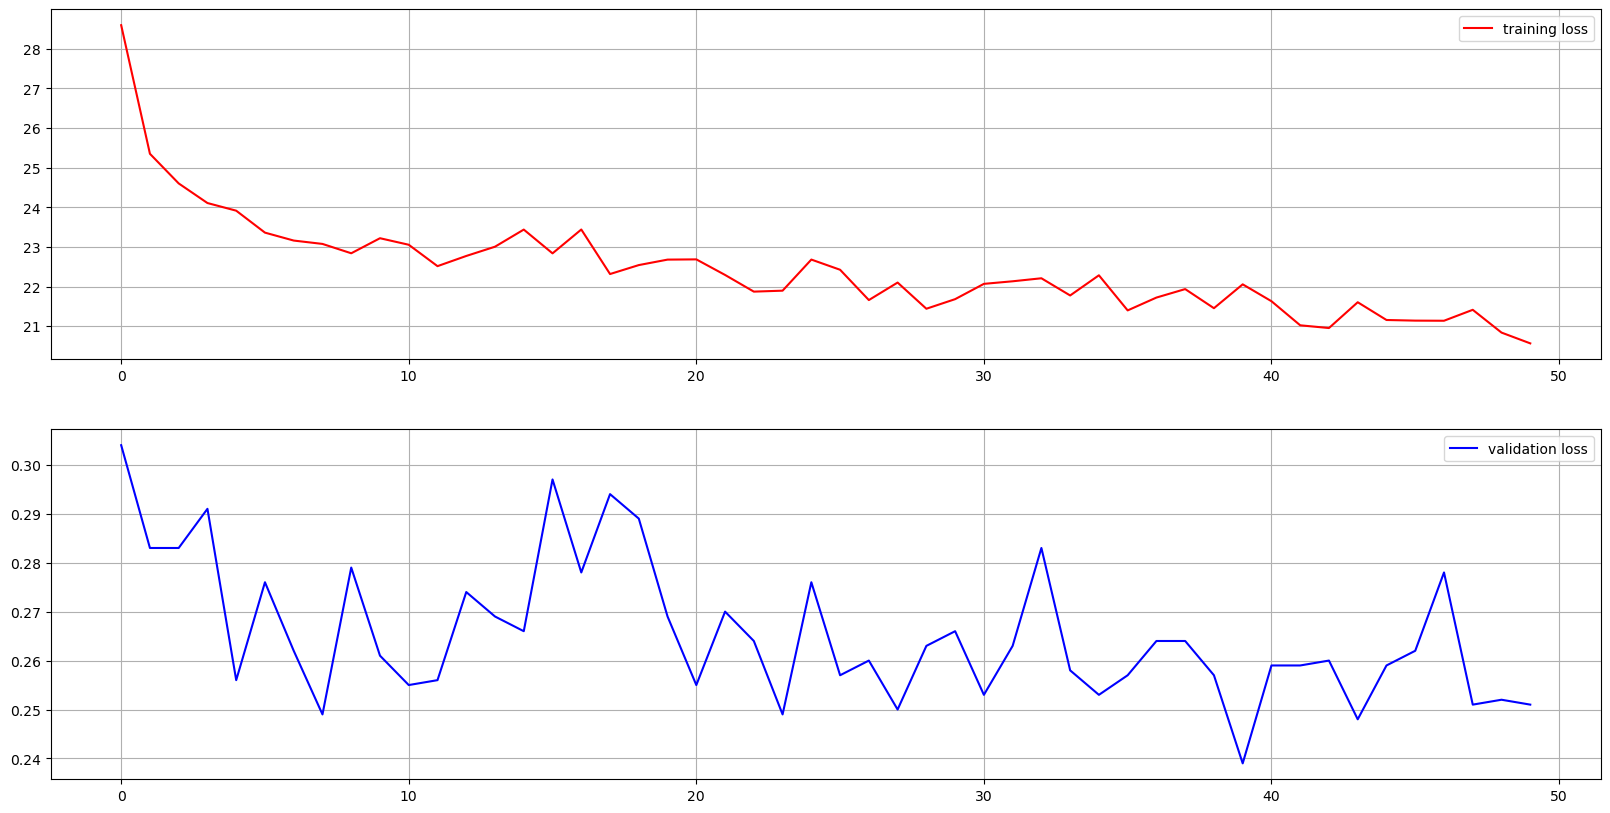

In [10]:
history = get_current_losses(os.path.join(opt.checkpoints_dir, opt.name, 'valid.log'))

#after the training loop returns, we can plot the data
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
  
fig, ax = plt.subplots(ncols = 1, nrows = 2, figsize = (20,10))
N = 1

ax[0].plot(running_mean(history['train_loss'], N), 'r-', label='training loss')
ax[1].plot(running_mean(history['valid_loss'], N), 'b-', label='validation loss')
for i in ax:
    i.legend()
    i.grid(True)
plt.show()